In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nengo
import gym
from gym import wrappers
from datetime import datetime
from prf_net import PRF
from rmsp import RMSP

In [2]:
def plot_running_avg(total_rewards):
    N = len(total_rewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = total_rewards[max(0, t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average of rewards")
    plt.xlabel("Simulation time")
    plt.ylabel("Score")
    plt.show()

In [3]:



class EnvironmentInterface(object):
    
    def __init__(self, env, step_size =5):
        self.env = env
        self.n_actions = env.action_space.n
        self.state_dim = env.observation_space.shape[0]
        self.t=0
        self.stepsize = step_size
        self.output = np.zeros(self.n_actions)
        self.state = env.reset()
        self.reward= 0
        self.current_action = 0
        self.reward_arr = []
        self.total_reward = 0

    def take_action(self,action):
        self.state,self.reward,self.done,_= self.env.step(action)
        self.total_reward += self.reward
        if self.done:
            self.reward = -2
            self.total_reward += self.reward
            self.reward_arr.append(self.total_reward)
            self.state = self.env.reset()
            self.total_reward = 0

    def get_reward(self,t):
        return self.reward
    
    def sensor(self,t):
        return self.state

    
    def step(self,t,x):
        if int(t*1000)%self.stepsize == 0:
            self.current_action = np.argmax(x) 
            self.take_action(self.current_action)
    
    def calculate_Q(self,t,x):

         if int(t*1000) % self.stepsize == 1:
            qmax = x[self.current_action]
            self.output = 0.9*qmax + self.reward
            
         return self.output
    
        

In [4]:
env = gym.make('CartPole-v0').env

env_iface=EnvironmentInterface(env)

state_dimensions=env_iface.state_dim
n_actions = env_iface.n_actions

filename="nengo_rl"
is_monitor=False

if is_monitor:
    monitor_dir = f'./{filename}_{datetime.now()}'
    env = wrappers.Monitor(env, monitor_dir)
    env.reset()




In [5]:
tau = 0.01

fast_tau = 0
slow_tau = 0.05


n_place = 100
n_input = 1000
n_inhibitory = 200

n_actor = n_place
n_critic = 50

sensor_radius = 2
actor_radius = 10

seed = 19

srf_params = {
          'isp_target_rate': 1.0,
          'w_actor': 0.01,
          'w_input': 0.1,
          'w_initial_E': 0.01, 
          'w_initial_EI': 1e-3,
          'w_initial_EE': 0.001, 
          'w_initial_I': -0.05, 
          'w_EI_Ext': 1e-3,
          'p_E': 0.05, 
          'p_EE': 0.01, 
          'p_EI': 0.1,
          'p_EI_Ext': 0.007,
          'sigma_scale_E': 0.002,
          'sigma_scale_EI': 0.025,
          'tau_E': 0.005, 
          'tau_I': 0.020, 
          'tau_input': 0.1,
          'learning_rate_I': 0.01, 
          'learning_rate_E': 0.005,
          'learning_rate_EE': 1e-4,
          'learning_rate_R': 1e-3
             }

    
model=nengo.Network()

with model:
    
    sensor = nengo.Node(env_iface.sensor)
    reward = nengo.Node(env_iface.get_reward)
    sensor_net = nengo.Ensemble(n_neurons=n_input, dimensions=env_iface.state_dim, radius=sensor_radius)

    srf_net = PRF(n_excitatory = n_input,
                  n_inhibitory = n_inhibitory,
                  connect_exc_inh_input=True,
                  n_outputs = n_place,
                  dimensions=env_iface.n_actions,
                  label="Spatial receptive field network",
                  seed=seed, **srf_params)

    actor_net = nengo.Ensemble(n_neurons=n_actor,
                               dimensions=env_iface.n_actions,
                               radius=actor_radius)
    
    
    sensor_conn = nengo.Connection(sensor, sensor_net)
    
    sensor_srf_conn = nengo.Connection(sensor_net.neurons, srf_net.exc.neurons, 
                                       synapse=nengo.Lowpass(tau), 
                                       transform=np.eye(n_input) *srf_params['w_input'])
    
    srf_actor_conn=nengo.Connection(srf_net.output.neurons, actor_net.neurons,
                                    synapse=nengo.Lowpass(tau),
                                    transform=np.eye(n_actor) * srf_params['w_actor'],
                                    learning_rule_type=RMSP(learning_rate=srf_params['learning_rate_R']))
    
    q_node = nengo.Node(env_iface.calculate_Q, size_in=2, size_out=1)
    
    step_node = nengo.Node(env_iface.step, size_in=2)
    
    nengo.Connection(actor_net, step_node, synapse=fast_tau)
    
    nengo.Connection(actor_net, q_node, synapse=tau)
    
    nengo.Connection(q_node, srf_actor_conn.learning_rule, synapse=fast_tau) ##0.9*Q(s',a')+r
    
 


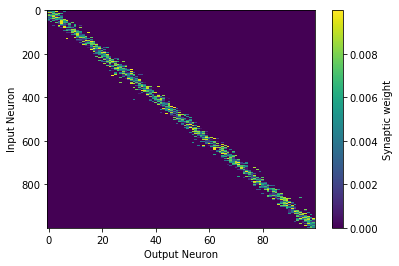

In [6]:
plt.imshow(srf_net.weights_initial_E.T, aspect='auto', interpolation='nearest')
plt.colorbar(label='Synaptic weight')
ax = plt.gca()
ax.set_xlabel('Output Neuron')
ax.set_ylabel('Input Neuron')
plt.show()


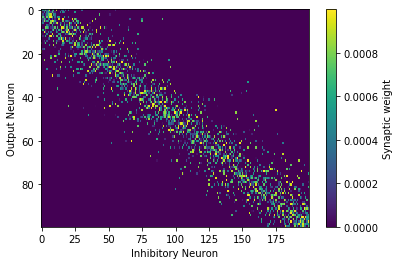

In [7]:
plt.imshow(srf_net.weights_initial_EI.T, aspect='auto', interpolation='nearest')
plt.colorbar(label='Synaptic weight')
ax = plt.gca()
ax.set_xlabel('Inhibitory Neuron')
ax.set_ylabel('Output Neuron')
plt.show()


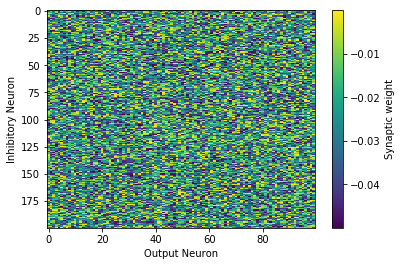

In [8]:
plt.imshow(srf_net.weights_initial_I.T, aspect='auto', interpolation='nearest')
plt.colorbar(label='Synaptic weight')
ax = plt.gca()
ax.set_xlabel('Output Neuron')
ax.set_ylabel('Inhibitory Neuron')
plt.show()


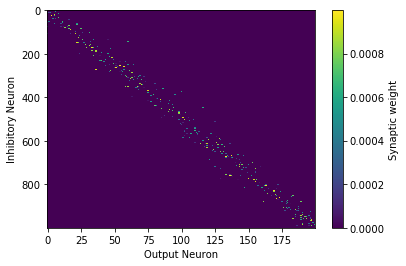

In [9]:
plt.imshow(srf_net.conn_EI_Ext.transform.init.T, aspect='auto', interpolation='nearest')
plt.colorbar(label='Synaptic weight')
ax = plt.gca()
ax.set_xlabel('Output Neuron')
ax.set_ylabel('Inhibitory Neuron')
plt.show()


In [10]:
from nengo_gui.ipython import IPythonViz
IPythonViz(model,'agent_model.py.cfg')

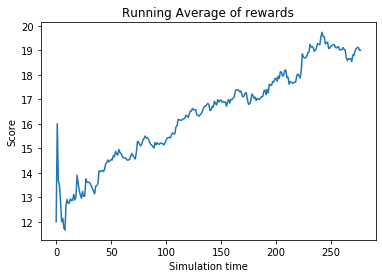

In [13]:
plot_running_avg(np.array(env_iface.reward_arr))


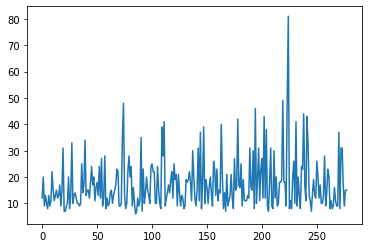

In [14]:
plt.plot(env_iface.reward_arr)